In [10]:
import keras
from keras.layers import Dense,Conv2D,MaxPool2D,Activation, Dropout, Flatten, Dense,BatchNormalization,Input ,LeakyReLU ,Reshape,Conv2DTranspose
from keras.models import Model,Sequential
from keras.optimizers import RMSprop
import numpy as np
import pandas as pandas
from keras.datasets import cifar10
import os

In [11]:
(X_train, y_train), (_,_) = cifar10.load_data()

In [12]:
print(X_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 1)


In [13]:
gen_input=Input(shape=(32,)) #random
x = Dense(16*16*128)(gen_input) #Generator starts with Dense due to its random dimension input
x = LeakyReLU()(x) 
x = Reshape((16,16,128))(x) 
x = Conv2D(256,5,padding="same")(x) #padding *
x = LeakyReLU()(x)
x = Conv2DTranspose(256, 4, strides=2, padding='same')(x) #upsampling to 32*32*3
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding='same')(x)
x = LeakyReLU()(x)
x = Conv2D(3,7, activation='tanh', padding='same')(x) #test value of 3 #tanh*
generator=Model(gen_input,x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

In [14]:
discr_input=Input(shape=(32,32,3)) #input that 32*32*3 to output fake/real=1
x = Conv2D(128,3)(discr_input)
x = LeakyReLU()(x)
x = Conv2D(128, 4,strides=2)(x) #strides*
x = LeakyReLU()(x)
x = Conv2D(128, 4,strides=2)(x)
x = LeakyReLU()(x)
x = Conv2D(128, 4,strides=2)(x)
x = LeakyReLU()(x)
x = Flatten()(x)
# One dropout layer - important trick!
x = Dropout(0.4)(x)
x = Dense(1,activation='sigmoid')(x)

discriminator=Model(discr_input, x)
discriminator.summary()
rmsprop=RMSprop(lr=0.0005,clipvalue=1.0,decay=1e-8) #gradient clipping
discriminator.compile(optimizer=rmsprop,loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 6, 6, 128)         0         
__________

In [15]:
discriminator.trainable = False # otherwise everytime it will predict real

gan=Sequential()
gan.add(generator)
gan.add(discriminator)
rmsprop=RMSprop(lr=0.0004,clipvalue=1.0,decay=1e-8)
gan.compile(optimizer=rmsprop, loss='binary_crossentropy')

In [16]:
X_train = X_train[y_train.flatten() == 0] # referring to one class in cifar10
print(X_train.shape)
#normalize
X_train = X_train.reshape((X_train.shape[0],) + (32,32,3)).astype('float32') / 255.

(5000, 32, 32, 3)


In [17]:
iterations = 30000
batch_size = 20

start = 0
for step in range(iterations):
    noise = np.random.normal(size=(batch_size,32)) # generate noise
    generated_images = generator.predict(noise) #predictions on noise
    stop = start + batch_size
    real_images = X_train[start: stop] #from cifar 10
    combined_images = np.concatenate([generated_images, real_images]) #sumup
    labels=np.concatenate([np.ones((batch_size, 1)),np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape) #noise****
    discr=discriminator.train_on_batch(combined_images, labels) #train d

    noise1 = np.random.normal(size=(batch_size,32))
    targets=np.zeros((batch_size, 1))
    my_gan=gan.train_on_batch(noise1,targets)
    
    start += batch_size
    if start > len(X_train) - batch_size:
        start = 0

    if step % 200 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discr loss-step %s: %s' % (step,discr))
        print('advers loss-step %s: %s' % (step,my_gan))

/opt/conda/lib/python3.6/site-packages/Keras-2.1.5-py3.6.egg/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discr loss-step 0: 0.68446004
advers loss-step 0: 0.675144
discr loss-step 200: 0.98984134
advers loss-step 200: 1.322448
discr loss-step 400: 0.7409316
advers loss-step 400: 0.8645509
discr loss-step 600: 0.7013113
advers loss-step 600: 0.7458898
discr loss-step 800: 0.6972533
advers loss-step 800: 0.7511028
discr loss-step 1000: 0.69062626
advers loss-step 1000: 0.77353114
discr loss-step 1200: 0.6890375
advers loss-step 1200: 0.73397696
discr loss-step 1400: 0.68760765
advers loss-step 1400: 0.7652089
discr loss-step 1600: 0.7000817
advers loss-step 1600: 0.7407502
discr loss-step 1800: 0.70030624
advers loss-step 1800: 0.7578681
discr loss-step 2000: 0.6960154
advers loss-step 2000: 0.73558646
discr loss-step 2200: 0.692631
advers loss-step 2200: 0.76051295
discr loss-step 2400: 0.69316584
advers loss-step 2400: 0.767181
discr loss-step 2600: 0.7003361
advers loss-step 2600: 0.79999614
discr loss-step 2800: 0.69449127
advers loss-step 2800: 0.7334269
discr loss-step 3000: 0.6875889

discr loss-step 24600: 0.69336116
advers loss-step 24600: 0.94533813
discr loss-step 24800: 0.6895734
advers loss-step 24800: 0.929883
discr loss-step 25000: 0.6966355
advers loss-step 25000: 1.0164387
discr loss-step 25200: 0.82976294
advers loss-step 25200: 0.93004924
discr loss-step 25400: 0.75535023
advers loss-step 25400: 0.99382704
discr loss-step 25600: 0.71453387
advers loss-step 25600: 0.8943674
discr loss-step 25800: 0.7733691
advers loss-step 25800: 0.97077453
discr loss-step 26000: 0.6520474
advers loss-step 26000: 0.84777355
discr loss-step 26200: 0.6829622
advers loss-step 26200: 0.7552847
discr loss-step 26400: 0.6609464
advers loss-step 26400: 1.4115832
discr loss-step 26600: 0.7252726
advers loss-step 26600: 0.91228616
discr loss-step 26800: 0.73771226
advers loss-step 26800: 1.1282413
discr loss-step 27000: 0.6076633
advers loss-step 27000: 1.117138
discr loss-step 27200: 0.6388968
advers loss-step 27200: 0.96676284
discr loss-step 27400: 0.6811762
advers loss-step 27

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


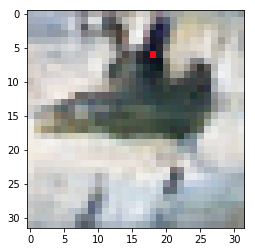

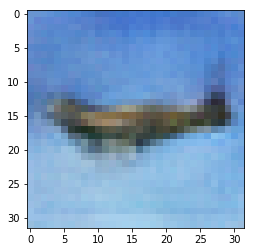

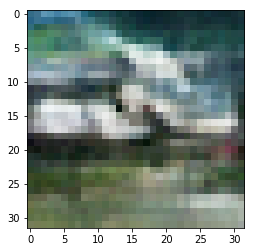

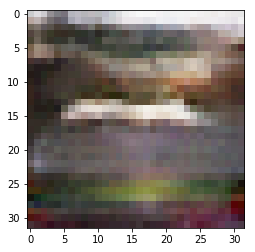

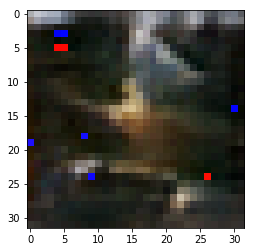

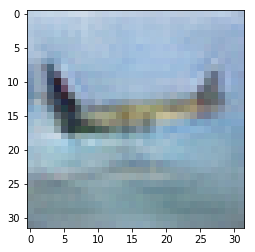

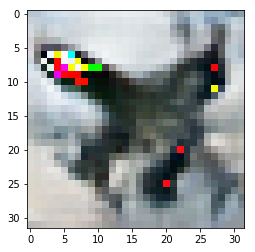

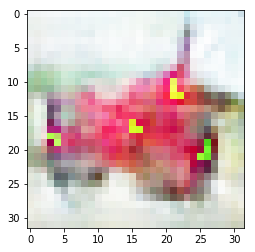

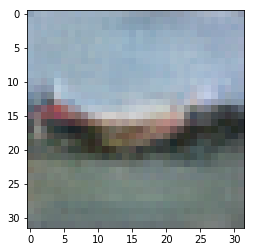

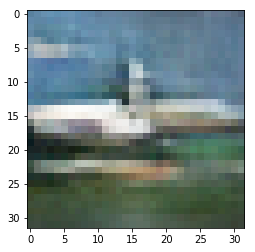

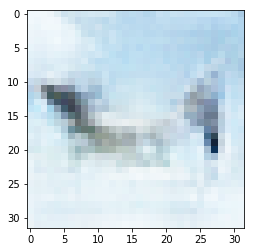

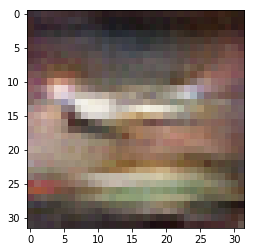

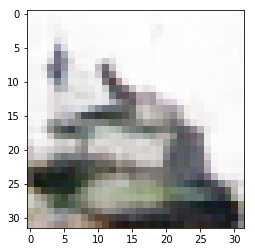

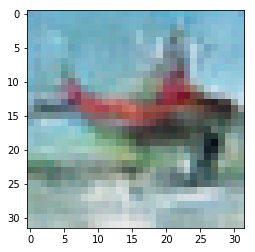

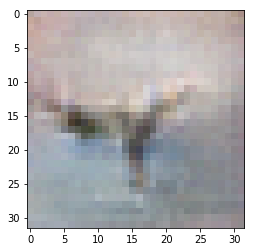

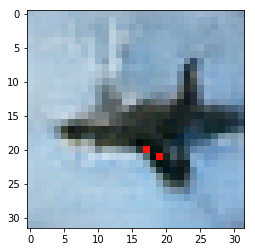

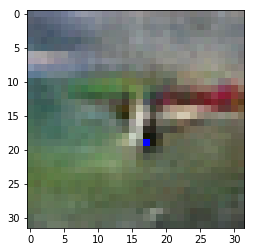

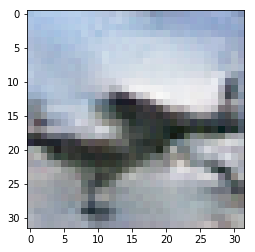

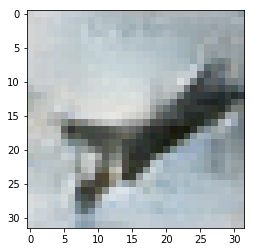

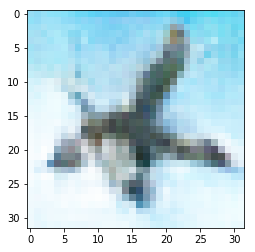

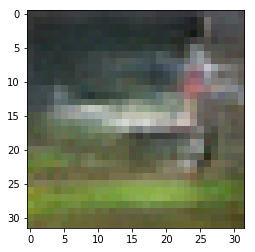

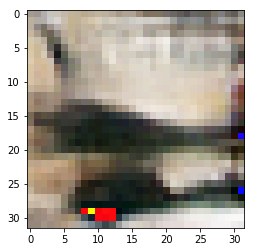

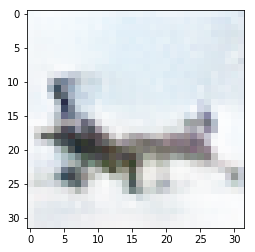

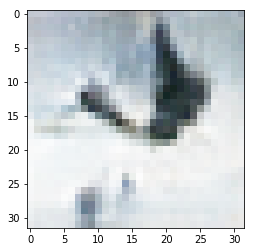

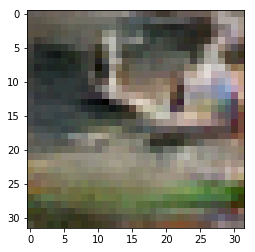

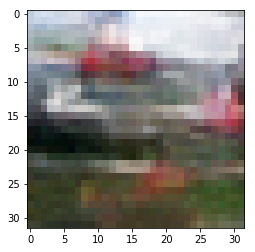

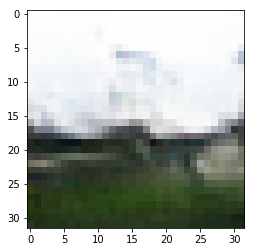

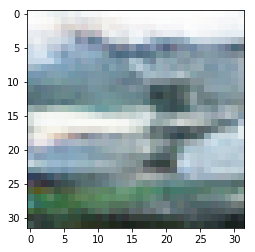

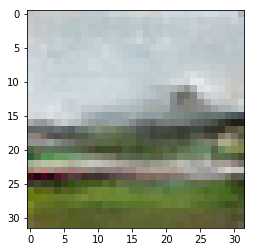

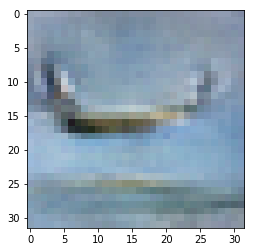

In [18]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
# Sample random points in the latent space
latent_dim=32
random_latent_vectors = np.random.normal(size=(30, latent_dim))
# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()